# Causal discovery of time series

Tigramite + TCDF tests

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

path_project = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_tcdf = path_project + '/src'
path_datasets = path_project + '/datasets'
path_tcdf_bash = path_tcdf.replace(' ', '\\ ')
path_datasets_bash = path_datasets.replace(' ', '\\ ')


sys.path.append(path_tcdf)
# sys.path

## 1: Time-series generation. Basic example.

Consider a dynamical system, which generates time series coming from a data generating process. 

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import tigramite
import tigramite.data_processing
import tigramite.plotting

sns.set(style='darkgrid')

In [47]:
def generate_ar_process(links_coeffs, time_steps, seed=0):
  np.random.seed(seed)
  return tigramite.data_processing.var_process(links_coeffs, T=time_steps)

def binarize(array, threshold):
  """
  https://stackoverflow.com/questions/33756995/fastest-way-to-filter-values-in-np-array-based-on-changing-threshold
  """
  thresholds = np.full(data.shape, threshold)
  binarized = np.empty(data.shape)

  for slice in range(data.shape[1]):
    binarized[:, slice] = list(map(lambda x: 1 if x == True else 0, (data > thresholds)[:, slice]))
  return binarized


time_steps, num_timeseries = 1000, 4 # exactly data.shape
time_grid = np.arange(time_steps)
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8), ((3, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                 3: [((3, -1), 0.1)],
               }

data, true_parents_neighbors = generate_ar_process(links_coeffs, time_steps)
data_binarized = binarize(data, 0.5)

dataframe = tigramite.data_processing.DataFrame(data)
dataframe_binarized = tigramite.data_processing.DataFrame(data_binarized)

In [48]:
print(np.shape(data)[0])
print(data)
print(data_binarized)

np.savetxt(path_datasets + '/generated/gen_ts.csv', data, header='x0,x1,x2,x3', comments='', delimiter=',')

1000
[[ 1.76405235e+00  5.55962680e-01 -1.53292105e+00  1.59327362e+00]
 [ 4.00157208e-01  8.92473887e-01 -1.71197016e+00  5.68722399e-01]
 [ 9.78737984e-01 -4.22314824e-01  4.61350590e-02 -1.14487046e-01]
 ...
 [ 3.80386709e+00 -1.47107753e+00 -1.98952081e+00 -4.00744211e-01]
 [ 5.77006721e+00 -1.76010212e+00 -1.31877778e+00 -6.83341432e-01]
 [ 4.61814765e+00 -2.15748942e+00 -1.12175009e+00  2.48037744e-03]]
[[1. 1. 0. 1.]
 [0. 1. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


## TCDF in Jupyter

In [50]:
from TCDF_wrapper import TCDF

dataset = path_datasets + '/generated/gen_ts.csv'
dataset_gt = path_datasets + '/generated/gen_ts_groundtruth_reverse.csv'

TCDF_solver = TCDF()
TCDF_solver.fit(dataset, verbose=1)


Analysis started for target:  x0
Potential causes: [1, 0]
Validated causes: [1, 0]

Analysis started for target:  x1
Potential causes: [1]
Validated causes: [1]

Analysis started for target:  x2
Potential causes: [2, 1]
Validated causes: [2, 1]

Analysis started for target:  x3
Potential causes: [3, 1]
Validated causes: [3, 1]


In [51]:
TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(dataset_gt)


========================== RESULTS =========================

x1 causes x0 with a delay of 1 time steps.
x0 causes x0 with a delay of 1 time steps.
x1 causes x1 with a delay of 1 time steps.
x2 causes x2 with a delay of 1 time steps.
x1 causes x2 with a delay of 2 time steps.
x3 causes x3 with a delay of 1 time steps.
x1 causes x3 with a delay of 2 time steps.



======================== EVALUATION ========================

⎡ Counts
|
| True Positives: 5
| False Positives: 2
| False Negatives: 2
| Direct True Positives: 5
⎣ Direct False Positives: 2

⎡ True Positives: [(0, 1), (0, 0), (1, 1), (2, 2), (2, 1)]
| False Positives: [(3, 3), (3, 1)]
| False Negatives: [(1, 3), (2, 3)]
| True Positives (direct): [(0, 1), (0, 0), (1, 1), (2, 2), (2, 1)]
⎣ False Positives (direct): [(3, 3), (3, 1)]

⎡ F1 score (includes direct and indirect causal relationships):
| 0.7142857142857143 (precision: 0.7142857142857143, recall: 0.7142857142857143)
|
| F1 score (direct) (includes only direct causal r

In [63]:
TCDF_solver.models['x3'].fs_attention.data.numpy()

array([[0.26320943],
       [1.1513263 ],
       [0.885826  ],
       [1.4443182 ]], dtype=float32)

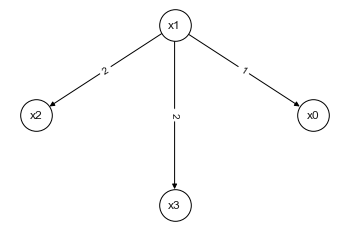

In [52]:
TCDF_solver.plotgraph()

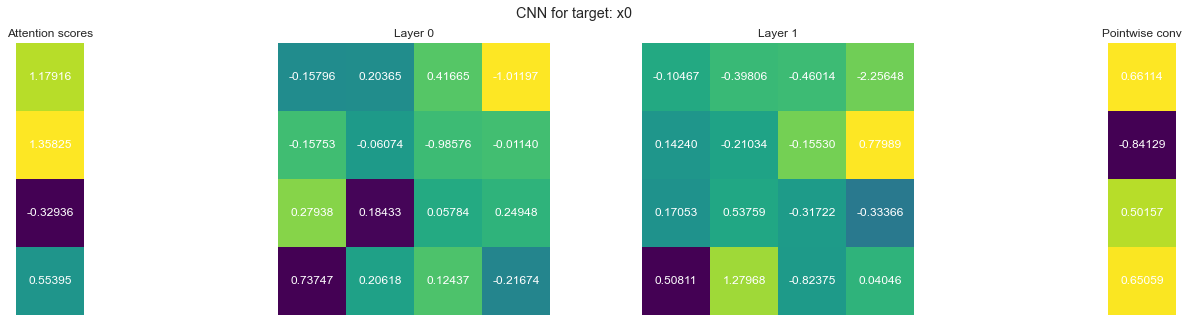

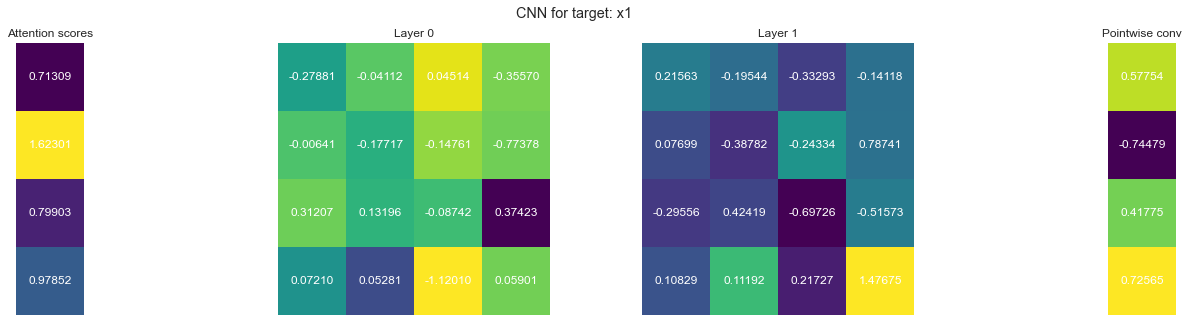

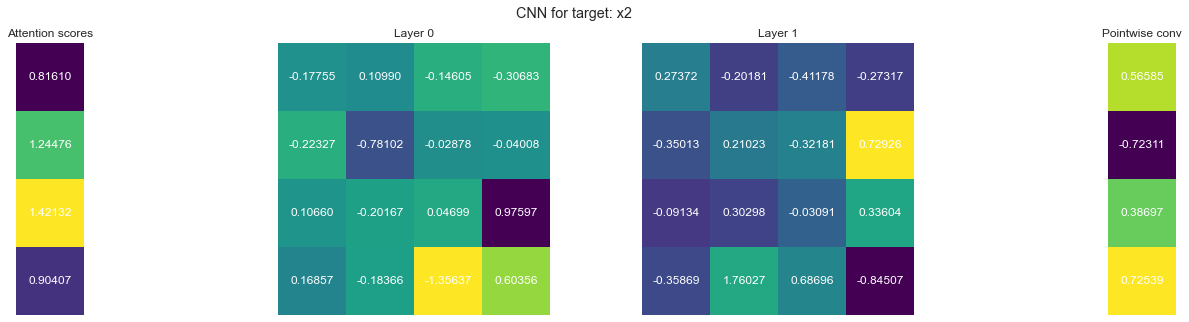

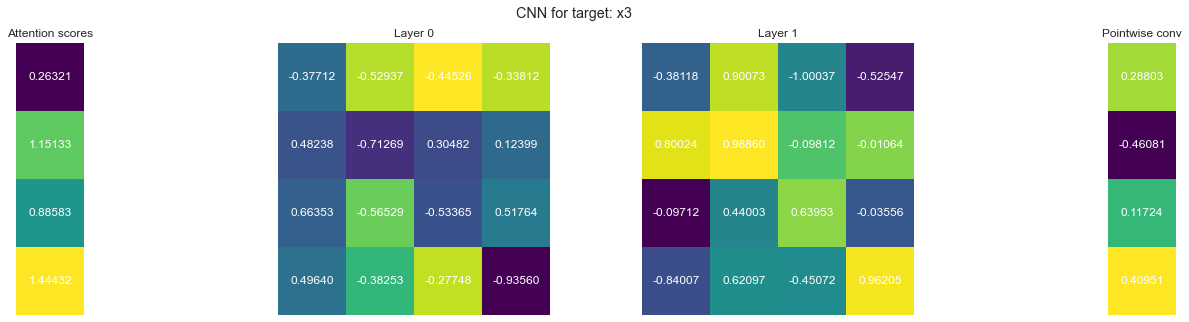

In [72]:
TCDF_solver.visualize_weights(pointwise=True, attention_scores=True)

## Miscellaneous

Could not import sklearn for GPACE
Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package
Could not import python ACE package for GPACE
Could not import statsmodels, p-value corrections not available.

## Estimating lagged dependencies


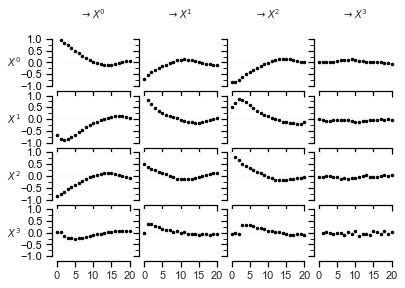

In [46]:
from tigramite.independence_tests import ParCorr
from tigramite.pcmci import PCMCI

parcorr = ParCorr(significance='analytic')

pcmci = PCMCI(dataframe=dataframe,
              cond_ind_test=parcorr,
              verbosity=1)

correlations = pcmci.get_lagged_dependencies(tau_max=20)

lag_func_matrix = tigramite.plotting.plot_lagfuncs(val_matrix=correlations,
                                                   setup_args={'var_names':var_names,
                                                               'x_base':5, 'y_base':.5})

pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)

plotting time series from first dynamical system


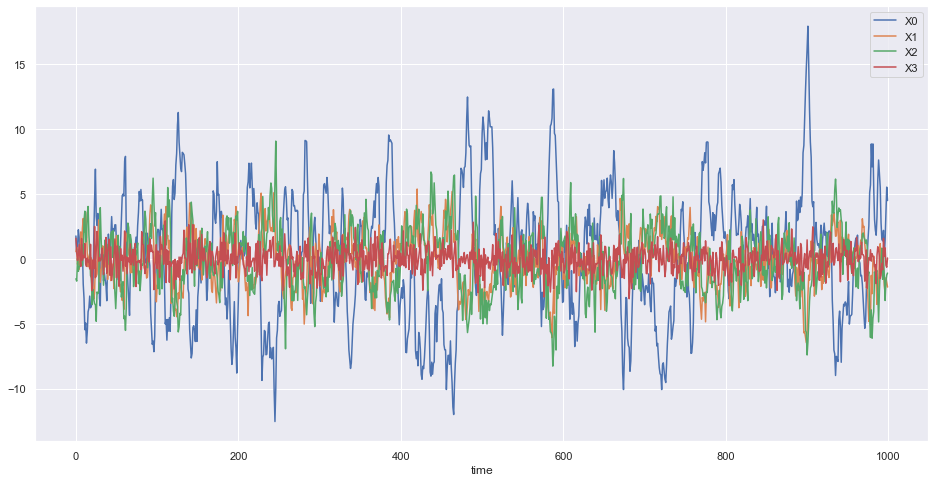

In [14]:
# tigramite.plotting.plot_timeseries(data, time_grid, var_names)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

print('plotting time series from first dynamical system')
ax.plot(dataframe.values[:,0])
ax.plot(dataframe.values[:,1])
ax.plot(dataframe.values[:,2])
ax.plot(dataframe.values[:,3])
ax.legend(['X0', 'X1', 'X2', 'X3'])

ax.set_xlabel('time')

plt.show()

plotting discrete time series


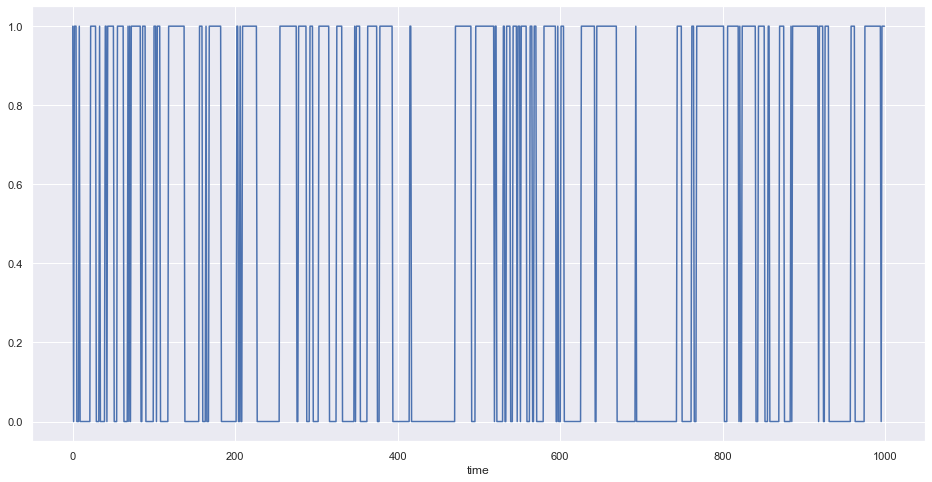

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

print('plotting discrete time series')
ax.plot(dataframe_binarized.values[:, 0])

ax.set_xlabel('time')

plt.show()